# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# Load dateset
data_tr = pd.read_csv("./data_topic/train.csv", header=None, names=['label','text'])
data_te = pd.read_csv("./data_topic/test.csv", header=None, names=['label','text'])
data_dev = pd.read_csv("./data_topic/dev.csv", header=None, names=['label','text'])

In [3]:
# transform test to list, and label to numpy arrays
def transform(df):
    return list(df['text']), df['label'].to_numpy().reshape(-1,1)

X_tr_raw, Y_tr = transform(data_tr)
X_te_raw, Y_te = transform(data_te)
X_dev_raw, Y_dev = transform(data_dev)

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    """N-gram extraction from a document.

    Args:
        x_raw: a string corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        vocab: a given vocabulary. It should be used to extract specific features.

    Returns:
        A list of terms to the corresponding N-gram. Each part fits one N-gram,
        except 1-gramrow. For example:

        ['great','movie','watch',
        ('great', 'movie'),('movie', 'watch'),
        ('great', 'movie', 'watch')]

    """
    
    def finder(s,n):
        if n <= 0 or n > len(s):
            raise Exception('n is out of range')
        if n == 1:
            return s
        else:
            return map(lambda i: tuple(s[i:i+n]),range(len(s)-n+1))

    # Find all words by condition
    pattern = re.compile(token_pattern)
    term_eligible = [term.lower() for term in pattern.findall(x_raw) if term.lower() not in stop_words]

    # Find combinations of different N-grams
    x = [term for n in range(ngram_range[0],ngram_range[1]+1) for term in finder(term_eligible,n)]
    
    if not vocab:    
        return x
    else:
        return [term for term in x if term in vocab]

def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    # this is to store the ngrams to be returned
    x = []
    
    if ngram_range[0]==1:
        x = x_uni
    
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        
        # ignore unigrams
        if n==1: continue
        
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternativel, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
    
        
    for n in ngrams:
        for t in n:
            x.append(t)
        
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    
    '''1. create a vocabulary of ngrams
       2. count the document frequencies of ngrams
       3. their raw frequency

    Args:
        X_raw: a list of strings each corresponding to the raw text of a document
        ngram_range: a tuple of two integers denoting the type of ngrams you want
            to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
        token_pattern: a string to be used within a regular expression to extract
            all tokens. Note that data is already tokenised so you could opt for
            a simple white space tokenisation.
        stop_words: a list of stop words
        min_df: keep ngrams with a minimum document frequency.
        keep_topN: keep top-N more frequent ngrams.

    Returns:
        vocab: a set of the n-grams that will be used as features.
        df: a Counter (or dict) that contains ngrams as keys and their corresponding
            document frequency as values.
        ngram_counts: counts of each ngram in vocab

    '''
    
    bag_of_ngrams = list()
    df = Counter()
    for line in X_raw:
        ngrams = extract_ngrams(line,ngram_range=ngram_range,token_pattern=token_pattern,stop_words=stop_words)
        bag_of_ngrams += ngrams
        df.update(set(ngrams))
    df = Counter({k:v for k,v in df.items() if v >=min_df})
    ngram_counts = Counter(bag_of_ngrams)
    
    vocab = [items[0] for items in ngram_counts.most_common() if items[0] in df.keys()][:keep_topN]

    return vocab, df, ngram_counts

def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['disappointed', 'taxes', 'erick', 'travelers', 'provide', 'disturbed', 'linked', 'expecting', 'endless', 'detainees', 'own', 'activities', 'theft', 'mission', 'wis', 'counted', 'training', 'purchased', 'fixed', 'people', 'would', 'george', 'involved', 'gear', 'flag', 'refusing', 'disrupting', 'bullet', 'yards', 'handful', 'hoogenband', 'brett', 'nld', 'gtw', 'hands', 'abu', 'dawn', 'concerned', 'try', 'mutiny', 'topple', 'georgia', 'objections', 'settled', 'bowa', 'ariel', 'confirmed', 'pinch', 'hopes', 'ferrari', 'victories', 'seattle', 'maoist', 'see', 'payments', 'shrine', 'economy', 'james', 'bicycle', 'idema', 'decline', 'leaders', 'dye', 'cbc', 'elections', 'managed', 'pretty', 'bracing', 'donations', 'qaeda', 'interview', 'pharmacare', 'access', 'shell', 'crossing', 'denied', 'withholding', 'sales', 'starting', 'lack', 'clashes', 'reactors', 'survive', 'totaling', 'requirements', 'upheld', 'fair', 'etched', 'fractured', 'ready', 'floods', 'allows', 'ramallah', 'cloud', 'a

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [8]:
# Calculate the vocab and df of different data sets
vocab_tr, df_tr, ngram_counts_tr = get_vocab(X_tr_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
vocab_te, df_te, ngram_counts_te = get_vocab(X_te_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(X_dev_raw, ngram_range=(1,1), keep_topN=5000, stop_words=stop_words)
# create reference
id2vocab = dict(enumerate(vocab_tr))
vocab2id = dict(zip(id2vocab.values(),id2vocab.keys()))

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
# extract n-grams
X_uni_tr = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in X_tr_raw]
X_uni_te = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in X_te_raw]
X_uni_dev = [extract_ngrams(line,ngram_range=(1,1),stop_words=stop_words) for line in X_dev_raw]

In [10]:
X_uni_tr[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [11]:
def words2indices(words,index = vocab2id):
    '''Convert a list of words to a list of index
    
    Args:
        words: a list of words
        index: a dictionart, each key is a word, and value is the index
    Return:
        a list of index
    '''
    #words = set(words)&set(vocab2id.keys())
    words = [word for word in words if word in index.keys()]
    return list(map(lambda x:index[x],words))

X_tr = [words2indices(line) for line in X_uni_tr]
X_te = [words2indices(line) for line in X_uni_te]
X_dev = [words2indices(line) for line in X_uni_dev]

In [12]:
X_uni_tr[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

In [13]:
X_tr[0]

[2721,
 1762,
 3950,
 3790,
 2835,
 1708,
 2004,
 3370,
 4638,
 1481,
 1577,
 3204,
 3747,
 1751,
 2071,
 2975,
 2308,
 2252,
 4176,
 3463,
 1196,
 789,
 3376,
 1620,
 3537,
 4334,
 1337]

Put the labels `Y` for train, dev and test sets into arrays: 

In [14]:
# Already transform at the beginning of reading CSV
Y_tr = Y_tr - 1
Y_te = Y_te - 1
Y_dev = Y_dev - 1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [15]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W_emb = np.random.uniform(low = -1*init_val, high = init_val, size = (vocab_size,embedding_dim))
    
    W_h = list()
    pt = embedding_dim
    for layer in hidden_dim:
        W_h.append(np.random.uniform(low = -1*init_val, high = init_val, size = (pt,layer)))
        pt = layer
    W_out = np.random.uniform(low = -1*init_val, high = init_val, size = (pt,num_classes))
    W = [W_emb,*W_h,W_out]

    return W

In [16]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [17]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [18]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [19]:
W[0]

array([[-0.40428748,  0.38532683,  0.12724897,  0.22341636],
       [-0.48387079,  0.09443188,  0.05678519, -0.34104036],
       [-0.34692948,  0.19552953, -0.18123357,  0.1919703 ]])

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [20]:
def softmax(z):
    
    '''Calculate softmax results
    
    In order to avoid data overflow, the corresponding data boundary is added.
    Since np.exp() is a `np.float64` operation function, so we need to avoid overflow.
    It is easy to find out the boundary of `np.float64` by calling np.finfo(np.float64).
    Usually, it should be written as `np.minimum(np.exp(z),np.finfo(np.float64).max)`,
    but I prefer to written inside the exp function, since it somehow can be faster.
    For the input of np.exp(), it should not be greater than 709.782 to ensure that the
    output will not overflow.
    
    Returns:
        z: the same size of z.
    '''
    
    z = z.copy()
    z = np.minimum(z,709.782)
    smax = np.exp(z) / np.sum(np.exp(z),axis=z.ndim-1,keepdims=True)
    
    return smax

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [21]:
def categorical_loss(y, y_preds):
    
    '''1. Calculate the Euclidean distance between label and probability
       2. Calculate the average distance
       
    Here I use `esp` to represent the smallest data unit of the data type. 
    The main function of `esp` is to ensure the rationality of arithmetic 
    operations. For example, in the division operation, add `esp` to the 
    denominator to ensure that the denominator is not 0, and it does not 
    affect the data result. This is the habit I developed when I wrote Matlab
    in my undergraduate period. `esp` is more common in Matlab.
    Input:
        y->int/list: 2;[2],[[2],[2]]
        y_preds->np.ndarry: [1,0,0];[[1,0,0]];[[1,0,0],[1,0,0]]
    Args:
        eps: the minimum value in the current data type. Used to ensure
            that the input of the log function is greater than 0.
        preds_proba: Probability of each data, the same
            size of input data.(X.shape[0])

    Returns:
        l: Used to save losses and calculate the average at the end
    '''
    
    Y = np.array(y)
    assert type(y_preds) == np.ndarray
    try:
        n,d = y_preds.shape
    except:
        n=1
        d = y_preds.shape[0]
    #eps = np.finfo(np.float64).eps
    Y = np.eye(d,d)[Y].reshape(n,d)
    assert np.all(y_preds>0)
    #l1 = -np.sum(Y*np.log(y_preds+eps),1) 
    l1 = -np.sum(Y*np.log(y_preds),1) 
    l=np.mean(l1)
    assert l>=0
    return l


In [22]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [23]:
def relu(z):
    a = np.fmax(z, 0)
    assert (a.shape == z.shape)
    return a
    
def relu_derivative(z):
    dz = np.fmax(z,0)
    dz = np.sign(dz)
    assert (dz.shape == z.shape)
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [24]:
def dropout_mask(size, dropout_rate):
    
    #dropout_vec = np.random.uniform(0,1,size)>dropout_rate
    #dropout_vec = np.random.rand(size)>dropout_rate
    
    dropout_vec = np.full(size,1.0)
    index = np.arange(size)
    np.random.shuffle(index)
    dropout_vec[index[:int(size*dropout_rate)]]=0
    
    return dropout_vec

In [25]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
[1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [26]:
def forward_pass_v0(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    w_0 = W[0]
    x_0 = np.eye(w_0.shape[0],w_0.shape[0])[x].sum(axis = 0)
    h_0 = 1/x_0.sum()*x_0.dot(w_0)
    a_0 = relu(h_0)
    dropout = dropout_mask(h_0.shape[0], dropout_rate)
    
    h_vecs.append(h_0);a_vecs.append(a_0);dropout_vecs.append(dropout)

    for i in range(len(W)):
        if i==0:
            a = a_0
            continue
        if i == len(W)-1:
            continue
        a = np.multiply(a,dropout)/(1-dropout_rate)
        h = np.dot(a,W[i])
        h_vecs.append(h)
        a = relu(h)
        a_vecs.append(a)
        dropout = dropout_mask(a.shape[0], dropout_rate)
        dropout_vecs.append(dropout)

    a = np.multiply(a,dropout)/(1-dropout_rate)
    y = softmax(np.dot(a,W[-1]))

    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = y
    
    return out_vals

def forward_pass_v1(x, W, dropout_rate=0.2):
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    
    try:
        x[0][0]
        n = len(x)
        x_dim = 2
    except:
        n = 1
        x_dim = 1
        
    #x = np.array(x)
    #x_dim = 2
    
    w_0 = W[0]
    #x_0 = np.eye(w_0.shape[0],w_0.shape[0])[x].sum(axis = x_dim-1)
    if x_dim == 2:
        x_0 = np.array([np.eye(w_0.shape[0],w_0.shape[0])[x_i].sum(axis = 0) for x_i in x])
    else:
        #x_0 = np.eye(w_0.shape[0],w_0.shape[0])[x].sum(axis = x_dim-1)
        x_0 = np.zeros(w_0.shape[0])
        x_0[x] = 1
    h_0 = 1/x_0.sum()*x_0.dot(w_0)
    a_0 = relu(h_0)
    dropout = dropout_mask(h_0.shape[x_dim-1], dropout_rate)
    
    h_vecs.append(h_0);a_vecs.append(a_0);dropout_vecs.append(dropout)

    a = a_0
    for i in range(len(W)):
        if i==0 or i == len(W)-1:
            continue
        a = np.multiply(a,dropout)/(1-dropout_rate)
        h = np.dot(a,W[i])
        a = relu(h)
        dropout = dropout_mask(a.shape[x_dim-1], dropout_rate)
        h_vecs.append(h);a_vecs.append(a);dropout_vecs.append(dropout)

    a = np.multiply(a,dropout)/(1-dropout_rate)
    h = np.dot(a,W[-1])
    a = relu(h)
    y = softmax(a)

    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = y
    
    return out_vals


In [27]:
def initial_a0(x,W):
    if type(x[0])!=list:
        a=np.zeros(W.shape[0])
        a[x]=1/len(x)
    else:
        n = len(x)
        d = W.shape[0]
        a = np.zeros((n,d))
        I = np.eye(d,d)
        for i in range(n):
            a[i,:] = I[x[i]].sum(axis = 0)/len(x[i])
    return a

def forward_linear(A_prev, W, dropout_rate):
    assert (type(A_prev)==np.ndarray)
    h = np.dot(A_prev,W)
    a = relu(h)
    dropout = dropout_mask(a.shape[a.ndim-1],dropout_rate)
    return h,a,dropout

def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    A = initial_a0(x,W[0])
    
    L = len(W)
    for l in range(L-1):
        A_prev = A 
        h,A,dropout = forward_linear(A_prev,W[l],dropout_rate)
        h_vecs.append(h);a_vecs.append(A);dropout_vecs.append(dropout)
        A = np.multiply(A,dropout)#/(1-dropout_rate)
        
    # Last layer don't record
    A_prev = A 
    h,A,dropout = forward_linear(A_prev,W[l+1],dropout_rate)
    A = np.multiply(A,dropout)#/(1-dropout_rate)
    y = softmax(A)
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vec'] = dropout_vecs
    out_vals['y'] = y
    
    return out_vals

In [28]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([-0.04668262, -0.12518335,  0.17532285, -0.32932054]), array([0., 0., 0., 0., 0.])], 'a': [array([0.        , 0.        , 0.17532285, 0.        ]), array([0., 0., 0., 0., 0.])], 'dropout_vec': [array([1., 0., 0., 1.]), array([0., 0., 1., 1., 1.])], 'y': array([0.5, 0.5])}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [29]:
def backward_linear(dh,A_prev,W):
    A_prev = A_prev.reshape(1,-1)
    dW = np.dot(A_prev.T, dh)
    dA_prev = np.dot(dh, W.T)
    return dW,dA_prev

def backward_activation_linear(dA, A_prev, W):
    dh = relu_derivative(A_prev @ W)*dA
    #dh = dA
    dW,dA_prev = backward_linear(dh, A_prev,W)
    return dW,dA_prev

def backward_dropout(dA, A_prev, W, dropout):
    h = np.dot(A_prev,W)
    a = relu(h)
    a = np.multiply(a,dropout)
    dh = relu_derivative(a)*dA
    dW,dA_prev = backward_linear(dh, A_prev,W)
    return dW,dA_prev
    

In [87]:
for _ in range(100000):
    a = np.random.randn(10)
    b = dropout_mask(10, 0.2)
    a = a * b

In [89]:
for _ in range(100000):
    a = np.random.randn(10)
    b = dropout_mask(10, 0.2)
    np.multiply(a,b,out = a)

In [72]:
dropout_mask(10, 0.2)

array([1., 1., 0., 0., 1., 1., 1., 1., 1., 1.])

In [100]:
def gradient_v0(x,y,W,out_vals):
    #assert type(y)==int

    Dw = list()
    Y = y
    y_preds = out_vals['y']
    
    try:
        n,d = y_preds.shape
    except:
        n=1
        d = y_preds.shape[0]

    eps = np.finfo(np.float64).eps
    Y = np.eye(d,d)[Y].reshape(n,d)

    dropout = out_vals['dropout_vec']
    a = out_vals['a'][-1].reshape(1,-1)
    #a = np.multiply(a,dropout[-1])/(1-dropout_rate)
    dw = -1*np.dot(a.T,(Y-Y*y_preds))
    assert W[-1].shape == dw.shape
    Dw.append(dw)


    a = out_vals['a'][-2].reshape(1,-1)
    #a = np.multiply(a,dropout[-2])/(1-dropout_rate)
    dw = -1*np.dot(relu_derivative(a.T),(Y-Y*y_preds)).dot(W[-1].T)
    dw = dw*dropout[-1]/(1-dropout_rate)
    assert W[-2].shape == dw.shape
    Dw.append(dw)

    a_0 = np.eye(W[0].shape[0],W[0].shape[0])[x].sum(axis = 0)
    a = a_0.reshape(1,-1)
    dw = -1*np.dot(relu_derivative(a.T),(Y-Y*y_preds)).dot(relu_derivative(W[-1].T)).dot(W[-2].T)
    dw = dw*dropout[-2]/(1-dropout_rate)
    assert W[-3].shape == dw.shape
    Dw.append(dw)

    Dw.reverse()
    return Dw

def gradient_v1(x,y,W,out_vals):
    
    D = []
    y_preds = out_vals['y']
    Y = np.eye(y_preds.shape[y_preds.ndim-1],y_preds.shape[y_preds.ndim-1])[y].reshape(len(y),-1)
    dA = -1*(Y-Y*y_preds)
    dA = y_preds-Y
    L = len(W)
    for l in range(L-1):
        A_prev = out_vals['a'][-1*(l+1)]
        dW,dA_prev = backward_activation_linear(dA, A_prev,W[-1*(l+1)])
        D.append(dW)
        dA = dA_prev
    A_prev = initial_a0(x,W[0])
    dW,dA_prev = backward_activation_linear(dA, A_prev,W[0])
    D.append(dW)
    D.reverse()
    
    return D

def gradient_v2(x,y,W,out_vals):
    
    D = []
    y_preds = out_vals['y']
    Y = np.eye(y_preds.shape[y_preds.ndim-1],y_preds.shape[y_preds.ndim-1])[y].reshape(len(y),-1)
    dA = -1*(Y-Y*y_preds)
    dA = y_preds-Y
    
    l=0
    A_prev = out_vals['a'][-1*(l+1)]
    dh = dA
    dW,dA_prev = backward_linear(dh, A_prev,W[-1])
    D.append(dW)
    dA = dA_prev
    
    L = len(W)
    for l in range(1,L-1):
        A_prev = out_vals['a'][-1*(l+1)]
        dropout = out_vals['dropout_vec'][-1*(l)]
        #dW,dA_prev = backward_activation_linear(dA, A_prev,W[-1*(l+1)])
        dW,dA_prev = backward_dropout(dA, A_prev,W[-1*(l+1)],dropout)
        D.append(dW)
        dA = dA_prev
        
    A_prev = initial_a0(x,W[0])
    dropout = out_vals['dropout_vec'][0]
    #dW,dA_prev = backward_activation_linear(dA, A_prev,W[0])
    dW,dA_prev = backward_dropout(dA, A_prev,W[0],dropout)
    D.append(dW)
    D.reverse()
    
    return D

def backward_pass_v2(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    W_new = [W[i].copy() for i in range(len(W))]
    dw = gradient(x,y,W,out_vals)
    for i in range(len(W)):
        W_new[i] = W_new[i] - lr*dw[i]
    
    return W_new

def gradient(x,Y,W,out_vals):
    D = []
    y_preds = out_vals['y']
    #Y = np.eye(y_preds.shape[y_preds.ndim-1],y_preds.shape[y_preds.ndim-1])[y].reshape(len(y),-1)
    dA = -1*(Y-Y*y_preds)
    dA = y_preds-Y
    
    l=0
    A_prev = out_vals['a'][-1*(l+1)]
    dh = dA
    dW,dA_prev = backward_linear(dh, A_prev,W[-1])
    D.append(dW)
    dA = dA_prev
    
    L = len(W)
    for l in range(1,L-1):
        A_prev = out_vals['a'][-1*(l+1)]
        dropout = out_vals['dropout_vec'][-1*(l)]
        #dW,dA_prev = backward_activation_linear(dA, A_prev,W[-1*(l+1)])
        dW,dA_prev = backward_dropout(dA, A_prev,W[-1*(l+1)],dropout)
        D.append(dW)
        dA = dA_prev
        
    A_prev = initial_a0(x,W[0])
    dropout = out_vals['dropout_vec'][0]
    #dW,dA_prev = backward_activation_linear(dA, A_prev,W[0])
    dW,dA_prev = backward_dropout(dA, A_prev,W[0],dropout)
    D.append(dW)
    #D.reverse()
    
    return D

def backward_pass(x, Y, W, out_vals, lr=0.001, freeze_emb=False):
    dw = gradient(x,Y,W,out_vals)
    for i in range(len(W)):
        #W[i] = W[i] - lr*dw[i]
        W[i] = W[i] - lr*dw[-1*(i+1)]
    return W

In [104]:
def backward_pass(x, Y, W, out_vals, lr=0.001, freeze_emb=False):
    y_preds = out_vals['y']
    #Y = np.eye(y_preds.shape[y_preds.ndim-1],y_preds.shape[y_preds.ndim-1])[y].reshape(len(y),-1)
    dA = -1*(Y-Y*y_preds)
    dA = y_preds-Y
    
    l=0
    A_prev = out_vals['a'][-1*(l+1)]
    dh = dA
    dW,dA_prev = backward_linear(dh, A_prev,W[-1])
    
    W[-1] -= lr*dW
    
    dA = dA_prev
    
    L = len(W)
    for l in range(1,L-1):
        A_prev = out_vals['a'][-1*(l+1)]
        dropout = out_vals['dropout_vec'][-1*(l)]
        #dW,dA_prev = backward_activation_linear(dA, A_prev,W[-1*(l+1)])
        dW,dA = backward_dropout(dA, A_prev,W[-1*(l+1)],dropout)
        W[-1*(l+1)] -= lr*dW

        
    A_prev = initial_a0(x,W[0])
    dropout = out_vals['dropout_vec'][0]
    #dW,dA_prev = backward_activation_linear(dA, A_prev,W[0])
    dW,dA_prev = backward_dropout(dA, A_prev,W[0],dropout)
    
    W[0] -= lr*dW
    
    return W

In [31]:
'''
x = [[0,1],[1,2],[3,4]]
y = np.array([[0],[1],[3]])
dropout_rate=0.2
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=4)

for e in range(3000):
    for i in range(len(x)):
        x_i,y_i = x[i],y[i]
        out_vals = forward_pass(x_i, W, dropout_rate=dropout_rate)
        W = backward_pass(x_i, y_i, W, out_vals, lr=0.01, freeze_emb=False)
    y_preds = forward_pass(x, W, dropout_rate=dropout_rate)['y']
    if e % 200 == 0:
        print(categorical_loss(y, y_preds))
print(y.T)    
np.argmax(forward_pass(x, W, dropout_rate=0)['y'],axis=1)
'''

"\nx = [[0,1],[1,2],[3,4]]\ny = np.array([[0],[1],[3]])\ndropout_rate=0.2\nW = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=4)\n\nfor e in range(3000):\n    for i in range(len(x)):\n        x_i,y_i = x[i],y[i]\n        out_vals = forward_pass(x_i, W, dropout_rate=dropout_rate)\n        W = backward_pass(x_i, y_i, W, out_vals, lr=0.01, freeze_emb=False)\n    y_preds = forward_pass(x, W, dropout_rate=dropout_rate)['y']\n    if e % 200 == 0:\n        print(categorical_loss(y, y_preds))\nprint(y.T)    \nnp.argmax(forward_pass(x, W, dropout_rate=0)['y'],axis=1)\n"

In [33]:
'''
x = [[2,1],[0],[2,1],[0],[0,3]]
y = np.array([[0],[1],[0],[1],[1]])
dropout_rate=0.2
loss = []
W = network_weights(vocab_size=4,embedding_dim=10,hidden_dim=[], num_classes=4)
W_tp = [W[i].copy() for i in range(len(W))]
for i in range(500):
    for i in range(len(x)):
        x_i,y_i = x[i],y[i]
        out_vals = forward_pass(x_i, W, dropout_rate=dropout_rate)
        #y_preds = out_vals['y']
        W = backward_pass(x_i, y_i, W, out_vals, lr=0.1, freeze_emb=False)
        #l += categorical_loss(y_i, y_preds)
    y_preds = forward_pass(x, W, dropout_rate=dropout_rate)['y']
    l = categorical_loss(y, y_preds)
    loss.append(l)
    if dropout_rate == 0:
        try:
            if loss[-1]>loss[-2]:
                break
        except:
            W_tp = [W[i].copy() for i in range(len(W))]
    
import matplotlib.pyplot as plt
plt.plot(range(len(loss)),loss)

print(y.T)
np.argmax(forward_pass(x, W, dropout_rate=0)['y'],axis=1)
'''

"\nx = [[2,1],[0],[2,1],[0],[0,3]]\ny = np.array([[0],[1],[0],[1],[1]])\ndropout_rate=0.2\nloss = []\nW = network_weights(vocab_size=4,embedding_dim=10,hidden_dim=[], num_classes=4)\nW_tp = [W[i].copy() for i in range(len(W))]\nfor i in range(500):\n    for i in range(len(x)):\n        x_i,y_i = x[i],y[i]\n        out_vals = forward_pass(x_i, W, dropout_rate=dropout_rate)\n        #y_preds = out_vals['y']\n        W = backward_pass(x_i, y_i, W, out_vals, lr=0.1, freeze_emb=False)\n        #l += categorical_loss(y_i, y_preds)\n    y_preds = forward_pass(x, W, dropout_rate=dropout_rate)['y']\n    l = categorical_loss(y, y_preds)\n    loss.append(l)\n    if dropout_rate == 0:\n        try:\n            if loss[-1]>loss[-2]:\n                break\n        except:\n            W_tp = [W[i].copy() for i in range(len(W))]\n    \nimport matplotlib.pyplot as plt\nplt.plot(range(len(loss)),loss)\n\nprint(y.T)\nnp.argmax(forward_pass(x, W, dropout_rate=0)['y'],axis=1)\n"

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

8.683094285608579
8.329531746376672
8.480926943854271
8.702435786967678
8.442478174864002
9.332776060654988
9.701580785910942
8.57008800411969
8.557308199338996
7.156703671588288
7.366749891631054
6.6393387637659425
5.021415155515617
3.903063301757323
3.4721731244839447
3.2870739872055097
2.352717264994184
2.392299020372508
1.9737976586636303
1.460235875144985
1.2338556995264474
1.1433673617486175
0.6419762606954903
0.7951689212349584
0.6055025054017052
Forward:  85.466872215271
Backward:  506.16901564598083


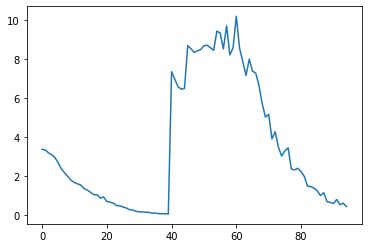

In [129]:
import time

dropout_rate = 0.2
#loss = []
num_classes = 3
W = network_weights(vocab_size=len(id2vocab.keys()),embedding_dim=300,hidden_dim=[150,150], num_classes=num_classes)
t_forward = 0
t_backward = 0
Y_tr_pre = np.eye(num_classes,num_classes)[Y_tr].reshape(len(Y_tr),-1)
for e in range(50):
    for i in range(len(X_tr)):
        t = time.time()
        #X_tr_i, Y_tr_i = X_tr[i],Y_tr[i]
        X_tr_i, Y_tr_i = X_tr[i],Y_tr_pre[i]
        out_vals = forward_pass(X_tr_i, W, dropout_rate=dropout_rate)
        t_forward += time.time()-t
        t = time.time()
        W = backward_pass(X_tr_i, Y_tr_i.reshape(1,-1), W, out_vals, lr=0.01, freeze_emb=False)
        t_backward += time.time()-t
        #if i>200:
        #    break
    y_preds = forward_pass(X_tr, W, dropout_rate=0)['y']
    l = categorical_loss(Y_tr, y_preds)
    loss.append(l)
    if e%2 == 0:
        print(l)

print("Forward: ",t_forward)
print("Backward: ",t_backward)
    
import matplotlib.pyplot as plt
plt.plot(range(len(loss)),loss)

In [130]:
y_preds = np.argmax(forward_pass(X_tr, W, dropout_rate=0)['y'],axis=1)
f1_score(Y_tr,y_preds,average='macro')

0.9657923489739703

In [131]:
y_preds = np.argmax(forward_pass(X_te, W, dropout_rate=0)['y'],axis=1)
f1_score(Y_te,y_preds,average='macro')

0.8123404580977601

In [7]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    
    # Stage 1: Init weights
    W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=3)
    
    # Stage 2: Init stochastic value
    idx_list = np.array(range(X_tr.shape[0]))
    
    for epoch in range(epochs):
        np.random.shuffle(idx_list) # disorder dataset
        for i in idx_list:
            X_tr_i, Y_tr_i = X_tr[i].reshape(1,-1),Y_tr[i].reshape(1,-1) # get a single data pair
            
            out_vals = forward_pass(X_tr_i, W, dropout_rate=dropout_rate)
            y_preds = out_vals['y']
            
            W = backward_pass(x, y, W, out_vals, lr=0.1, freeze_emb=False)
            l = categorical_loss(y, y_preds)
                  
        #loss_dev = categorical_loss(X_dev, Y_dev)
        #loss_tr = categorical_loss(X_tr, Y_tr)

        # Add history
        training_loss_history.append(loss_tr)
        validation_loss_history.append(loss_dev)
        
        if print_progress == True: 
            print("Epoch: %d| Training loss: %f| Validation loss: %f"%(epoch,loss_tr,loss_dev))
            
        if epoch >1 and abs(validation_loss_history[-2]-validation_loss_history[-1]) <= tolerance:
            break
    
    return W, training_loss_history, validation_loss_history

In [ ]:
x = [[2,1],[0,0]]
y = [0,1]
dropout_rate=0
loss = []
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=4)
for i in range(500):
    for i in range(len(x)):
        x_i,y_i = x[i],y[i]
        out_vals = forward_pass(x_i, W, dropout_rate=dropout_rate)
        y_preds = out_vals['y']
        W = backward_pass(x_i, y_i, W, out_vals, lr=0.01, freeze_emb=False)
        #l += categorical_loss(y_i, y_preds)
    y_preds = forward_pass(x, W, dropout_rate=dropout_rate)['y']
    l = categorical_loss(y, y_preds)
    
    loss.append(l)
    
import matplotlib.pyplot as plt
plt.plot(range(len(loss)),loss)

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [9]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=100)


Plot the learning process:

Compute accuracy, precision, recall and F1-Score:

In [10]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

### Discuss how did you choose model hyperparameters ? 

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [32]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [33]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [14]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

### Discuss how did you choose model hyperparameters ? 

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [13]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |   |   |   |   |
| Average Embedding (Pre-trained)  |   |   |   |   |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |   |   |   |   |
